In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 10
macro_configs = config_generator(N=[2000, 4000])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [3]:
N = params['N']
N_cavities = 20
N_total = N + N_cavities

f_modes = 0.2
K = int(f_modes * N)
U = np.random.normal(0, 1/np.sqrt(N), (N_cavities, K))
VT = np.random.normal(0, 1/np.sqrt(N), (K, N))
g_eff = 20
g = g_eff
S = np.ones(K)
S = g_eff * S / np.sqrt((S**2).sum()/N)
W_cavity = np.einsum('ik, k, kj -> ij', U, S, VT)
del U
del VT
W = g_eff*np.random.normal(0, 1/np.sqrt(N), (N_total, N_total))
W[:,:N_cavities] = 0
W[:N_cavities,N_cavities:] = W_cavity

#W = g_eff*np.random.normal(0, 1/np.sqrt(N), (N, N))

In [4]:
W_ = torch.from_numpy(W).type(torch.FloatTensor).to(0)
dt = 0.1
#dt_save = 1
#x, r_lpf = run_torch_sim(30000, dt_save, dt, W_)
dt_save = 0.1
x, r_lpf = run_torch_sim(30000, dt_save, dt, W_)

In [5]:
phi_numpy = lambda x: erf((np.sqrt(np.pi)/2)*x)
phi_prime = lambda x: np.exp(-(np.pi/4)*x**2)
r = phi_numpy(x)

In [6]:
#Compute theoretical Psi_phi_somp
C_phi_emp = np.fft.irfft((np.abs(np.fft.rfft(r[:20000,N_cavities:], axis=0, norm='ortho'))**2).mean(1))
T_window = 100
n_window = int(T_window/dt_save)
C_phi_emp = np.concatenate([C_phi_emp[:n_window], C_phi_emp[-n_window:]])
C_phi_emp_omega = fft(C_phi_emp, dt_save)
alpha_emp = phi_prime(x).mean()

T = len(C_phi_emp)
t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
sampfreq = 1/dt_save
w = 2*np.pi*sampfreq*t_indices/T
nu = (g*alpha_emp)**2

#theory for psi
Chi = np.multiply.outer(1 + 1j*w, 1 + 1j*w)

M = np.abs(Chi/(Chi - nu))**2 - 1

C_phi_C_phi = np.multiply.outer(C_phi_emp_omega, C_phi_emp_omega)
FPsi_phi_somp = M * C_phi_C_phi
Psi_phi_somp = ifft(FPsi_phi_somp, dt_save)

In [7]:
#calculate psi tau USV
n_derangements = 5
T_save = 100
n_window = int(T_save/dt_save)
r_cav = r[:,:N_cavities]
dLag = 1
lags = np.arange(0, T_save, dLag)
CCs = []
for i in range(n_derangements):
    CC = np.zeros((len(lags), N_cavities))
    for i_lag, lag in enumerate(lags):
        shuffle_idx = random_derangement(N_cavities)
        #shuffle_idx = range(N_cavities)
        #r1 = r_cav[:-(1+int(lag/dt_save)),shuffle_idx]
        #r2 = r_cav[(1+int(lag/dt_save)):,:]
        r1 = np.roll(r_cav[:,shuffle_idx], int(lag/dt_save), axis=0)
        r2 = r_cav
        CC[i_lag] = (r1 * r2).sum(0)/(r1.shape[0] - 1)
    CCs.append(CC)
CCs = np.concatenate(CCs, axis=1)
Psi_USV_emp_tau = (CCs**2).mean(1) * N

In [ ]:
plt.plot(lags, Psi_USV_emp_tau)
#plt.plot(lags, np.diag(Psi_phi_somp)[:T//2:int(dLag/dt_save)])
#plt.plot(lags, Psi_somp_emp_tau)

In [17]:
#calculate psi tau somp
n_derangements = 1
T_save = 100
n_window = int(T_save/dt_save)
r_somp = r[:,N_cavities:N_cavities+100]
#r_somp = r
dLag = 1
lags = np.arange(0, T_save, dLag)
CCs = []
for i in range(n_derangements):
    CC = np.zeros((len(lags), 100))
    for i_lag, lag in enumerate(lags):
        shuffle_idx = random_derangement(100)
        r1 = np.roll(r_somp[:,shuffle_idx], int(lag/dt_save), axis=0)
        r2 = r_somp
        CC[i_lag] = (r1 * r2).sum(0)/(r1.shape[0] - 1)
    CCs.append(CC)
CCs = np.concatenate(CCs, axis=1)
Psi_somp_emp_tau = (CCs**2).mean(1) * N

In [16]:
CC

(299000, 100)

In [ ]:
#plt.plot(lags, Psi_USV_emp_tau)
#plt.plot(lags, Psi_somp_emp_tau)
#time = np.arange(0, T_save, dt_save)
#plt.plot(time, np.diag(Psi_USV_tau_theory[:len(time)]))
#plt.plot(time, np.diag(Psi_phi_somp[:len(time)]))

In [18]:
#calculate theoretical psi USV
q4 = g_eff**4 / f_modes
S_phi = alpha_emp/(np.sqrt(2*np.pi)*(1 + 1j*w))
S_phi_S_phi = np.multiply.outer(S_phi, S_phi)
Psi_USV_omega = (2*np.pi)**2 * np.abs(S_phi_S_phi)**2 * (FPsi_phi_somp + (g_eff**4 + q4)*C_phi_C_phi)
Psi_USV_tau_theory = ifft(Psi_USV_omega, dt_save)

In [19]:
processed_data = np.array([np.diag(Psi_phi_somp)[0:T//2:int(dLag/dt_save)],
                           Psi_USV_emp_tau,
                           Psi_somp_emp_tau,
                           np.diag(Psi_USV_tau_theory)[0:T//2:int(dLag/dt_save)]])

/home/om2382/.conda/envs/torch-test-3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/om2382/.conda/envs/torch-test-3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


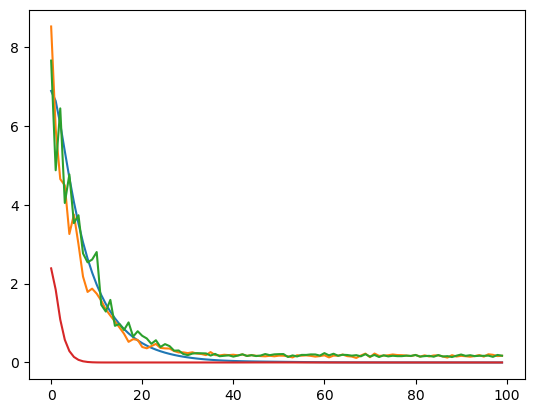

In [20]:
plt.plot(processed_data.T)

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [ ]:
###Truncate file above
file_name = 'USV_cavity_currents'
job_name = 'psi_somp_usv'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

In [ ]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=16, n_hours=1, n_gpus=1)
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False)

In [ ]:
###Get job status
get_ipython().system('squeue -u om2382')

In [ ]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'psi_somp_usv'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array, results_array, key_order, sim_dict = unpack_processed_data(job_script_path)

In [ ]:
results_array.shape

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(5, 12))
for i in range(2):
    for j in range(10):
        for k in range(4):
            ax[i].plot(results_array[i,j,k,:], color='C{}'.format(k), alpha=0.1)
            ax[i].plot(results_array[i,:,k,:].mean(0), color='C{}'.format(k), alpha=1)

In [ ]:
for i in range(3):
    plt.plot(results_array[i].mean(0).mean(1))

In [ ]:
#calculate single-unit properties for somp
somp_autocov = np.fft.ifft(np.abs(np.fft.fft(r[:,N_cavities:], axis=0, norm='ortho'))**2, axis=0).mean(1)
C_phi = fft(somp_autocov[:n_window], dt_save)
alpha_emp = phi_prime(x[:,N_cavities:]).mean()
f = np.fft.fftfreq(n_window, d=dt_save)
S_phi = alpha_emp/(np.sqrt(2*np.pi)*(1 + (0 + 1j)*2*np.pi*f))
#S_phi_S_phi = np.multiply.outer(S_phi, S_phi)
S_phi_S_phi = S_phi**2
#C_phi_C_phi = np.multiply.outer(C_phi, C_phi)
C_phi_C_phi = C_phi**2

In [ ]:
#calculate psi omega and tau somp
Fr = np.fft.fft(r[:,N_cavities:], axis=0) * dt_save/np.sqrt(2*np.pi)
N_samples = 1000
F_CCs = []
Psi_Somp_omega = 0
shuffle_idx = random_derangement(N)[:N_samples]
for i in range(N_samples):
    F_CC = np.conjugate(Fr[:,shuffle_idx[i]]) * Fr[:,i]
    Psi_Somp_omega += F_CC**2
Psi_Somp_omega = Psi_Somp_omega / N_samples * N
Psi_Somp_tau = np.fft.ifft(Psi_Somp_omega)[:n_window] * np.sqrt(2*np.pi) / dt_save
Psi_Somp_omega = fft(Psi_Somp_tau, dt_save)

In [ ]:
#calculate single-unit properties for somp
somp_autocov = np.fft.ifft(np.abs(np.fft.fft(r[:,N_cavities:], axis=0, norm='ortho'))**2, axis=0).mean(1)
C_phi = fft(somp_autocov[:n_window], dt_save)
alpha_emp = phi_prime(x[:,N_cavities:]).mean()
f = np.fft.fftfreq(n_window, d=dt_save)
S_phi = alpha_emp/(np.sqrt(2*np.pi)*(1 + (0 + 1j)*2*np.pi*f))
#S_phi_S_phi = np.multiply.outer(S_phi, S_phi)
S_phi_S_phi = S_phi**2
#C_phi_C_phi = np.multiply.outer(C_phi, C_phi)
C_phi_C_phi = C_phi**2

In [ ]:
#calculate psi tau USV
Fr = np.fft.fft(r[:,:N_cavities], axis=0, norm='ortho')
n_derangements = 10
T_save = 200
n_window = int(T_save/dt_save)
CCs = []
for i in range(n_derangements):
    shuffle_idx = random_derangement(N_cavities)
    F_CC = np.conjugate(Fr[:,shuffle_idx]) * Fr
    CCs.append(np.fft.ifft(F_CC, axis=0)[:n_window])
CCs = np.concatenate(CCs, axis=1)
Psi_USV_emp_tau = (CCs**2).mean(1) * N
#calculate psi tau somp
Fr = np.fft.fft(r[:,N_cavities:N_cavities+100], axis=0, norm='ortho')
n_derangements = 10
T_save = 200
n_window = int(T_save/dt_save)
CCs = []
for i in range(n_derangements):
    shuffle_idx = random_derangement(100)
    F_CC = np.conjugate(Fr[:,shuffle_idx]) * Fr
    CCs.append(np.fft.ifft(F_CC, axis=0)[:n_window])
CCs = np.concatenate(CCs, axis=1)
Psi_somp_emp_tau = (CCs**2).mean(1) * N